In [ ]:
!pip install xgboost

In [ ]:
!pip install lightgbm

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

import seaborn as sns
df = sns.load_dataset('titanic').copy()

y = df['survived'].astype(int)
X = df.drop(columns=['survived'])

num_feats = ['age','fare','sibsp','parch', 'pclass']
cat_feats = ['sex', 'embarked','class','who','adult_male','alone']

In [ ]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, num_feats),
    ('cat', categorical_pipe, cat_feats)
],
                               remainder='drop'
                               )

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
models = {
    'LogReg': LogisticRegression(max_iter=2000, n_jobs=None),
    'RandomForest': RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_leaf=2, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=800,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1

    ),
    'LightGBM': LGBMClassifier(
        objective='binary',
        n_estimators=1500,
        learning_rate=0.1,
        num_leaves=63,
        max_bin=500,
        min_child_samples=10,
        min_child_weight=1e-4,
        min_split_gain=0.0,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        force_row_wise=True,
        class_weight=None,
        random_state=42,
        n_jobs=-1

    )
}

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'logloss':'neg_log_loss',
    'accuracy':'accuracy',
    'roc_auc':'roc_auc'
}

cv_results = []

for name, clf in models.items():
  pipe = Pipeline([
      ('prep',preprocess),
      ('clf',clf)
  ])

  cv = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)
  cv_results.append({
      'model':name,
      'logloss_mean': -cv['test_logloss'].mean(),
      'logloss_std':cv['test_logloss'].std(),
      'roc_auc_mean': cv['test_roc_auc'].mean(),
      'accuracy_mean': cv['test_accuracy'].mean()
  })

cv_table = pd.DataFrame(cv_results).sort_values('logloss_mean')
cv_table

,model,logloss_mean,logloss_std,roc_auc_mean,accuracy_mean
1,RandomForest,0.406291,0.024467,0.884683,0.841755
0,LogReg,0.423345,0.021079,0.865971,0.822666
3,XGBoost,0.466806,0.047957,0.875023,0.817049
2,GradientBoosting,0.480024,0.063072,0.877516,0.820382
4,LightGBM,1.218874,0.209305,0.854860,0.802436


In [ ]:
df['survived'].mean()

np.float64(0.3838383838383838)

# Resampling

In [ ]:
df = pd.read_csv('credit_dataset.csv')

In [ ]:
df = df.iloc[:,1:]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25134 entries, 0 to 25133
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              25134 non-null  int64  
 1   GENDER          25134 non-null  object 
 2   CAR             25134 non-null  object 
 3   REALITY         25134 non-null  object 
 4   NO_OF_CHILD     25134 non-null  int64  
 5   INCOME          25134 non-null  float64
 6   INCOME_TYPE     25134 non-null  object 
 7   EDUCATION_TYPE  25134 non-null  object 
 8   FAMILY_TYPE     25134 non-null  object 
 9   HOUSE_TYPE      25134 non-null  object 
 10  FLAG_MOBIL      25134 non-null  int64  
 11  WORK_PHONE      25134 non-null  int64  
 12  PHONE           25134 non-null  int64  
 13  E_MAIL          25134 non-null  int64  
 14  FAMILY SIZE     25134 non-null  float64
 15  BEGIN_MONTH     25134 non-null  int64  
 16  AGE             25134 non-null  int64  
 17  YEARS_EMPLOYED  25134 non-null 

In [ ]:
df['TARGET'].mean()

np.float64(0.01679000557014403)

In [ ]:
minority = df[df['TARGET']==1]
majority = df[df['TARGET']==0]

<Axes: xlabel='INCOME', ylabel='Count'>

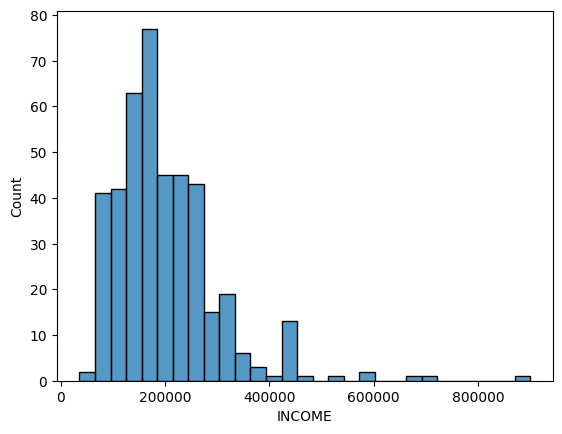

In [ ]:
sns.histplot(minority['INCOME'])


<Axes: xlabel='INCOME', ylabel='Count'>

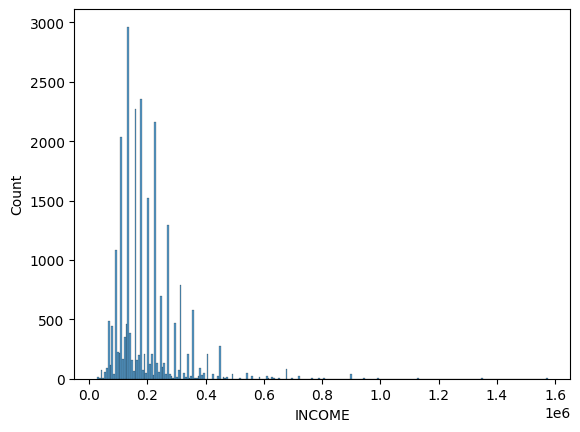

In [ ]:
sns.histplot(majority['INCOME'])

In [ ]:
minority.groupby('EDUCATION_TYPE')['ID'].count()/len(minority)

,ID
EDUCATION_TYPE,
Higher education,0.303318
Incomplete higher,0.049763
Lower secondary,0.014218
Secondary / secondary special,0.632701


In [ ]:
majority.groupby('EDUCATION_TYPE')['ID'].count()/len(majority)

,ID
EDUCATION_TYPE,
Academic degree,0.000567
Higher education,0.283425
Incomplete higher,0.039333
Lower secondary,0.007324
Secondary / secondary special,0.669351


In [ ]:
pip install imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X.dropna(inplace=True)

In [ ]:
y= y.loc[X.index.to_list()]

In [ ]:
X = X[['pclass','age','fare']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
smote = SMOTE(random_state=42, k_neighbors=5)

In [ ]:
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
X_res

,pclass,age,fare
0,1,45.500000,28.500000
1,1,29.000000,66.600000
2,2,3.000000,26.000000
3,3,25.000000,7.650000
4,1,37.000000,52.554200
...,...,...,...
193,1,40.226192,55.994611
194,1,20.969774,51.596599
195,1,5.422414,159.756950
196,1,16.335857,151.550000


In [ ]:
X

,pclass,age,fare
1,1,38.0,71.2833
3,1,35.0,53.1000
6,1,54.0,51.8625
10,3,4.0,16.7000
11,1,58.0,26.5500
...,...,...,...
871,1,47.0,52.5542
872,1,33.0,5.0000
879,1,56.0,83.1583
887,1,19.0,30.0000


In [ ]:
df = pd.read_csv('credit_dataset.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25134 entries, 0 to 25133
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      25134 non-null  int64  
 1   ID              25134 non-null  int64  
 2   GENDER          25134 non-null  object 
 3   CAR             25134 non-null  object 
 4   REALITY         25134 non-null  object 
 5   NO_OF_CHILD     25134 non-null  int64  
 6   INCOME          25134 non-null  float64
 7   INCOME_TYPE     25134 non-null  object 
 8   EDUCATION_TYPE  25134 non-null  object 
 9   FAMILY_TYPE     25134 non-null  object 
 10  HOUSE_TYPE      25134 non-null  object 
 11  FLAG_MOBIL      25134 non-null  int64  
 12  WORK_PHONE      25134 non-null  int64  
 13  PHONE           25134 non-null  int64  
 14  E_MAIL          25134 non-null  int64  
 15  FAMILY SIZE     25134 non-null  float64
 16  BEGIN_MONTH     25134 non-null  int64  
 17  AGE             25134 non-null 

In [ ]:
df.drop(columns=['ID','Unnamed: 0'], inplace=True)

In [ ]:
df.groupby("TARGET")['GENDER'].count()/len(df)

,GENDER
TARGET,
0,0.98321
1,0.01679


In [ ]:
df.describe()

,NO_OF_CHILD,INCOME,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
count,25134.000000,2.513400e+04,25134.0,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000,25134.000000
mean,0.512334,1.948339e+05,1.0,0.273812,0.292791,0.100660,2.294064,26.120594,40.536166,7.204106,0.016790
std,0.787785,1.045110e+05,0.0,0.445923,0.455052,0.300885,0.947590,16.439658,9.559474,6.414231,0.128486
min,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,0.000000,0.000000
25%,0.000000,1.350000e+05,1.0,0.000000,0.000000,0.000000,2.000000,12.000000,33.000000,3.000000,0.000000
50%,0.000000,1.800000e+05,1.0,0.000000,0.000000,0.000000,2.000000,24.000000,40.000000,5.000000,0.000000
75%,1.000000,2.250000e+05,1.0,1.000000,1.000000,0.000000,3.000000,39.000000,48.000000,10.000000,0.000000
max,19.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,20.000000,60.000000,67.000000,43.000000,1.000000


In [ ]:
df.head(1)

,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,INCOME_TYPE,EDUCATION_TYPE,FAMILY_TYPE,HOUSE_TYPE,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,29,59,3,0


In [ ]:
num_feats = ['INCOME','NO_OF_CHILD','FAMILY SIZE','BEGIN_MONTH','AGE','YEARS_EMPLOYED']
cat_feats = ['GENDER','CAR','REALITY','INCOME_TYPE','EDUCATION_TYPE','FAMILY_TYPE','HOUSE_TYPE']

In [ ]:
numeric = Pipeline([('imputer', SimpleImputer(strategy='median')),
                    ('scale', StandardScaler(with_mean=False))])
categorical = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

prep = ColumnTransformer([('num',numeric, num_feats),('cat',categorical, cat_feats)], remainder='drop')

In [ ]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.groupby(y_train).count()/len(y_train)

,TARGET
TARGET,
0,0.983289
1,0.016711


In [ ]:
y_test.groupby(y_test).count()/len(y_test)

,TARGET
TARGET,
0,0.982892
1,0.017108


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
lr = Pipeline([
    ('prep',prep),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=None, random_state=42))
])

rf = Pipeline([
    ('prep',prep),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42))
])

gb = Pipeline([
    ('prep',prep),
    ('gb', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42))
])

xgb = Pipeline([
    ('prep',prep),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

lgbm = Pipeline([
    ('prep',prep),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

In [ ]:
models = {'LR':lr,'RF':rf,'GB':gb,'XGB':xgb,'LGBM':lgbm}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {'accuracy':'accuracy', 'roc_auc':'roc_auc', 'f1':'f1', 'precision':'precision', 'recall':'recall', 'neg_log_loss':'neg_log_loss'}

In [ ]:
cv_rows = []

for name, pipe in models.items():
  res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
  cv_rows.append({
      'model':name,
      'acc_mean': res['test_accuracy'].mean(),
      'auc_mean': res['test_roc_auc'].mean(),
      'f1_mean': res['test_f1'].mean(),
      'prec_mean': res['test_precision'].mean(),
      'recall_mean': res['test_recall'].mean(),
      'logloss_mean': -res['test_neg_log_loss'].mean()
  })

cv_df = pd.DataFrame(cv_rows).sort_values("auc_mean", ascending=False)
cv_df

,model,acc_mean,auc_mean,f1_mean,prec_mean,recall_mean,logloss_mean
1,RF,0.983339,0.800181,0.261315,0.500477,0.178358,0.091890
3,XGB,0.982543,0.778608,0.228819,0.447100,0.154653,0.093027
2,GB,0.983140,0.760903,0.147700,0.470220,0.089113,0.074721
4,LGBM,0.982494,0.756430,0.230457,0.435386,0.157638,0.167210
0,LR,0.983737,0.670928,0.051855,1.000000,0.026734,0.080369


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# PIPELINES WITH RESAMPLING

lr_under = ImbPipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=None, random_state=42))
])

lr_over = ImbPipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=None, random_state=42))
])

lr_smote = ImbPipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=2000, n_jobs=None, random_state=42))
])

rf_under = ImbPipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42))
])

rf_over = ImbPipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42))
])

rf_smote = ImbPipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42))
])


gb_under = ImbPipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('gb', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42))
])

gb_over = ImbPipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('gb', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42))
])

gb_smote = ImbPipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('gb', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42))
])

xgb_under = ImbPipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

xgb_over = ImbPipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

xgb_smote = ImbPipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

lgbm_under = ImbPipeline([
    ('prep',prep),
    ('under', RandomUnderSampler(random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

lgbm_over = ImbPipeline([
    ('prep',prep),
    ('over', RandomOverSampler(random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

lgbm_smote = ImbPipeline([
    ('prep',prep),
    ('smote', SMOTE(random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.1, random_state=42))
])

# WEIGHTED MODELS
lr_weighted = Pipeline([
    ('prep',prep),
    ('lr', LogisticRegression(max_iter=2000, class_weight = 'balanced', n_jobs=None, random_state=42))
])

rf_weighted = Pipeline([
    ('prep',prep),
    ('rf', RandomForestClassifier(n_estimators=1000, class_weight='balanced',max_depth=None, random_state=42))
])

xgb_weighted = Pipeline([
    ('prep',prep),
    ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.1, scale_pos_weight=(len(y_train[y_train==0])/len(y_train[y_train==1])), random_state=42))
])

lgbm_weighted = Pipeline([
    ('prep',prep),
    ('lgbm', LGBMClassifier(n_estimators=1000, class_weight='balanced',learning_rate=0.1, random_state=42))
])

In [ ]:
models = {'LR':lr,'RF':rf,'GB':gb,'XGB':xgb,'LGBM':lgbm,
          'lr_weighted':lr_weighted, 'rf_weighted':rf_weighted,
          'xgb_weighted':xgb_weighted, 'lgbm_weighted':lgbm_weighted,
          'lr_under':lr_under, 'lr_over':lr_over, 'lr_smote':lr_smote,
          'rf_under':rf_under, 'rf_over':rf_over, 'rf_smote':rf_smote,
          'gb_under':gb_under, 'gb_over':gb_over, 'gb_smote':gb_smote,
          'xgb_under':xgb_under, 'xgb_over':xgb_over, 'xgb_smote':xgb_smote,
          'lgbm_under':lgbm_under, 'lgbm_over':lgbm_over, 'lgbm_smote':lgbm_smote
          }

In [ ]:
cv_rows = []

for name, pipe in models.items():
  res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
  cv_rows.append({
      'model':name,
      'acc_mean': res['test_accuracy'].mean(),
      'auc_mean': res['test_roc_auc'].mean(),
      'f1_mean': res['test_f1'].mean(),
      'prec_mean': res['test_precision'].mean(),
      'recall_mean': res['test_recall'].mean(),
      'logloss_mean': -res['test_neg_log_loss'].mean()
  })

cv_df = pd.DataFrame(cv_rows).sort_values("auc_mean", ascending=False)
cv_df

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,model,acc_mean,auc_mean,f1_mean,prec_mean,recall_mean,logloss_mean
13,rf_over,0.981399,0.801186,0.299371,0.404532,0.237840,0.126919
1,RF,0.983339,0.800181,0.261315,0.500477,0.178358,0.091890
6,rf_weighted,0.982891,0.799065,0.226832,0.454957,0.151536,0.091258
14,rf_smote,0.980156,0.798780,0.294718,0.361345,0.249824,0.097420
3,XGB,0.982543,0.778608,0.228819,0.447100,0.154653,0.093027
20,xgb_smote,0.981748,0.769382,0.290293,0.417819,0.223047,0.091218
7,xgb_weighted,0.979858,0.766655,0.313311,0.367831,0.273661,0.108864
19,xgb_over,0.979907,0.763295,0.306370,0.365012,0.264750,0.108545
2,GB,0.983140,0.760903,0.147700,0.470220,0.089113,0.074721
23,lgbm_smote,0.982742,0.758761,0.309403,0.465758,0.231914,0.135584


In [ ]:
# SHAP and LIME
!pip install shap

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7d2abbb263934c6a3923115f8ef739643d3e4f5b0e9029744dca0b6e7e006497
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import shap

In [ ]:
# feature names from the pipelines

def get_final_feature_names(prep, num_feats, cat_feats):
  # original names
  num_out = np.array(num_feats, dtype=object)

  #cat names
  cat_trans = prep.named_transformers_['cat']
  ohe = cat_trans.named_steps['onehot']
  cat_out = ohe.get_feature_names_out(cat_feats)
  return np.concatenate([num_out, cat_out])

In [ ]:
# transform X using only the prep step

def transform_X(pipeline, X_df):
  prep = pipeline.named_steps['prep']
  X_prep = prep.transform(X_df)
  # ensures dense matrix
  if hasattr(X_prep, "toarray"):
    X_prep = X_prep.toarray()
  return X_prep

In [ ]:
# get the estimator

def get_estimator(pipe):
  for name, step in reversed(pipe.named_steps.items()):
    if hasattr(step, 'predict'):
      return step
    raise RuntimeError('No estimator found')

In [ ]:
# lgbm_smote

best_pipe = models['lgbm_smote'] # sub in any of the models we built
best_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 19771, number of negative: 19771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7486
[LightGBM] [Info] Number of data points in the train set: 39542, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['INCOME', 'NO_OF_CHILD',
                                                   'FAMILY SIZE', 'BEGIN_MONTH',
                                                   'AGE', 'YEARS_EMPLOYED']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GENDER', 'CAR', 'REALITY',
                                                   'INCOME_TYPE',
                                                   'EDUCATION_TYPE',
                                                   'FAMILY_TYPE',
                                                   'HOUSE_TYPE'])])),
                ('smote', SMOTE(random_state=42)),
                ('lgbm', LGBMClassifier(n_estimators=1000, random_state=42))])

In [ ]:
prep = best_pipe.named_steps['prep']

In [ ]:
prep

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale',
                                                  StandardScaler(with_mean=False))]),
                                 ['INCOME', 'NO_OF_CHILD', 'FAMILY SIZE',
                                  'BEGIN_MONTH', 'AGE', 'YEARS_EMPLOYED']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GENDER', 'CAR', 'REALITY', 'INCOME_TYPE',
                                  'EDUCATION_TYPE', 'FAMILY_TYPE',
                                  'HOUSE_TYPE'])])

In [ ]:
feature_names = get_final_feature_names(prep, num_feats, cat_feats)

In [ ]:
feature_names

array(['INCOME', 'NO_OF_CHILD', 'FAMILY SIZE', 'BEGIN_MONTH', 'AGE',
       'YEARS_EMPLOYED', 'GENDER_F', 'GENDER_M', 'CAR_N', 'CAR_Y',
       'REALITY_N', 'REALITY_Y', 'INCOME_TYPE_Commercial associate',
       'INCOME_TYPE_Pensioner', 'INCOME_TYPE_State servant',
       'INCOME_TYPE_Student', 'INCOME_TYPE_Working',
       'EDUCATION_TYPE_Academic degree',
       'EDUCATION_TYPE_Higher education',
       'EDUCATION_TYPE_Incomplete higher',
       'EDUCATION_TYPE_Lower secondary',
       'EDUCATION_TYPE_Secondary / secondary special',
       'FAMILY_TYPE_Civil marriage', 'FAMILY_TYPE_Married',
       'FAMILY_TYPE_Separated', 'FAMILY_TYPE_Single / not married',
       'FAMILY_TYPE_Widow', 'HOUSE_TYPE_Co-op apartment',
       'HOUSE_TYPE_House / apartment', 'HOUSE_TYPE_Municipal apartment',
       'HOUSE_TYPE_Office apartment', 'HOUSE_TYPE_Rented apartment',
       'HOUSE_TYPE_With parents'], dtype=object)

In [ ]:
Xp_train = transform_X(best_pipe, X_train)

In [ ]:
background = shap.sample(Xp_train, 100)

In [ ]:
est = get_estimator(best_pipe)

In [ ]:
est

LGBMClassifier(n_estimators=1000, random_state=42)

In [ ]:
model_name = est.__class__.__name__.lower()

In [ ]:
model_name

'lgbmclassifier'

In [ ]:
pos_idx = 1 if hasattr(est, "predict_proba") else None

In [ ]:
if "forest" in model_name or "xgb" in model_name or 'lgbm' in model_name:
  explainer = shap.TreeExplainer(est, data=background, feature_perturbation="interventional")
  shap_values = explainer.shap_values(Xp_train)
  if isinstance(shap_values, list):
    shap_values = shap_values[pos_idx]

100%|===================| 20080/20107 [13:27<00:01]       

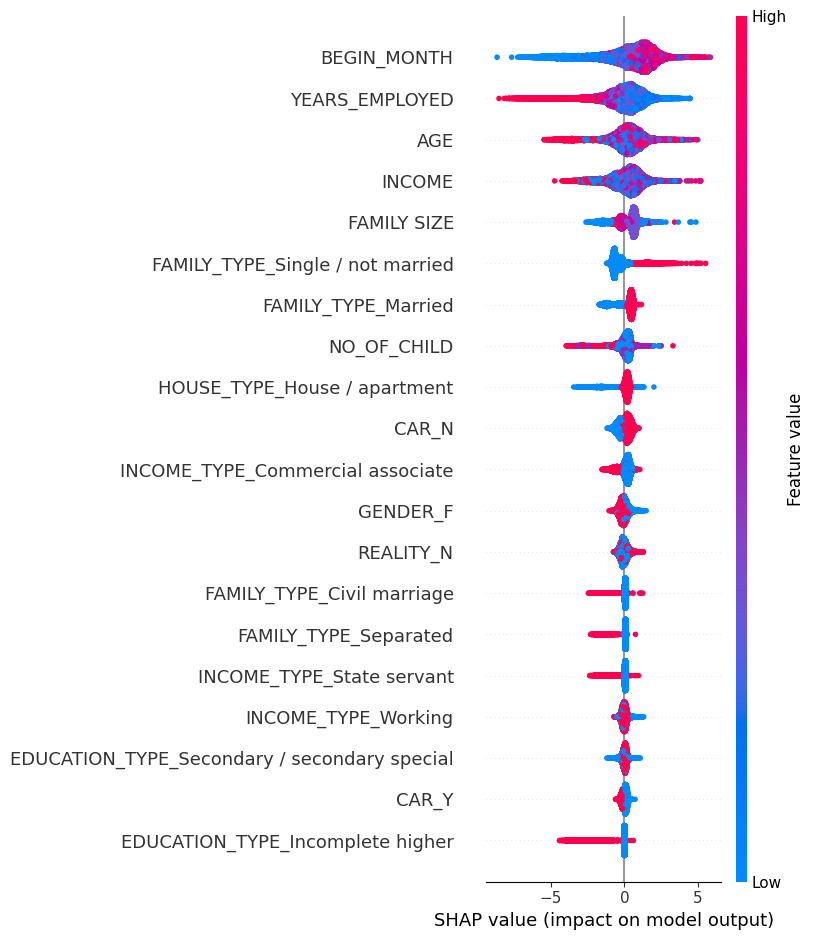

In [ ]:
shap.summary_plot(shap_values, Xp_train, feature_names=feature_names, show=True)


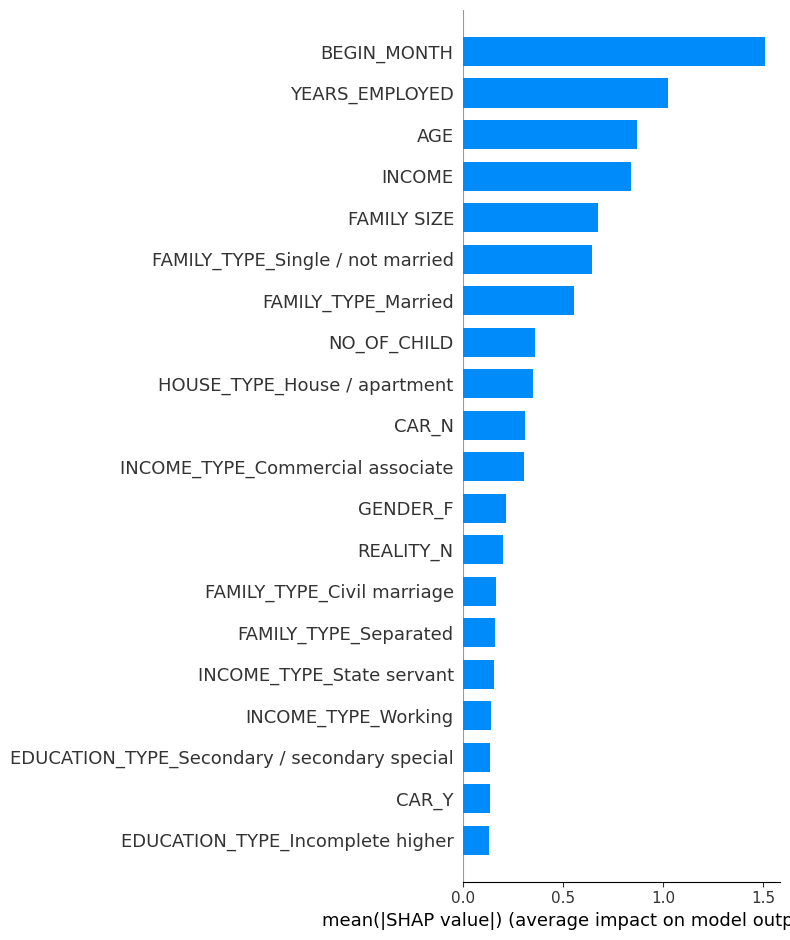

In [ ]:
shap.summary_plot(shap_values, Xp_train, feature_names=feature_names, plot_type="bar", show=True)

In [ ]:
i = 0  # pick any index to explain
xp = Xp_train[i:i+1]
shap.force_plot(explainer.expected_value, shap_values[i], xp, feature_names=feature_names, matplotlib=True)
